# Introduction
To Black Box Classifier Interpretation Using VEGAS Monte Carlo Integration

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import copy
import itertools
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

np.random.seed(0)

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The Iris data set is used as it is not overly complex.

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Remove setosa flowers as am only interested in true or false

In [4]:
df = df[df["species"] != "setosa"]
species = df["species"]

Drop species as it is the target.

In [5]:
df = df.drop(["species"], axis=1)

Rename columns as they are annoyingly long.

In [6]:
df.columns = ["s" + str(i) for i, _ in enumerate(df.columns)]

Scale the data (this is essential given the proposed model).
TODO: Change sclaing function to negate sparsity of data, saving the transform function.

In [7]:
df = df.select_dtypes(include=np.number)
scaler = MinMaxScaler()
scale = scaler.fit_transform(df)
scaled = pd.DataFrame(scale)
scaled.columns = df.columns
scaled.head()

,s0,s1,s2,s3
0,0.700000,0.666667,0.435897,0.266667
1,0.500000,0.666667,0.384615,0.333333
2,0.666667,0.611111,0.487179,0.333333
3,0.200000,0.166667,0.256410,0.200000
4,0.533333,0.444444,0.410256,0.333333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116f52c90>,
      dtype=object)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


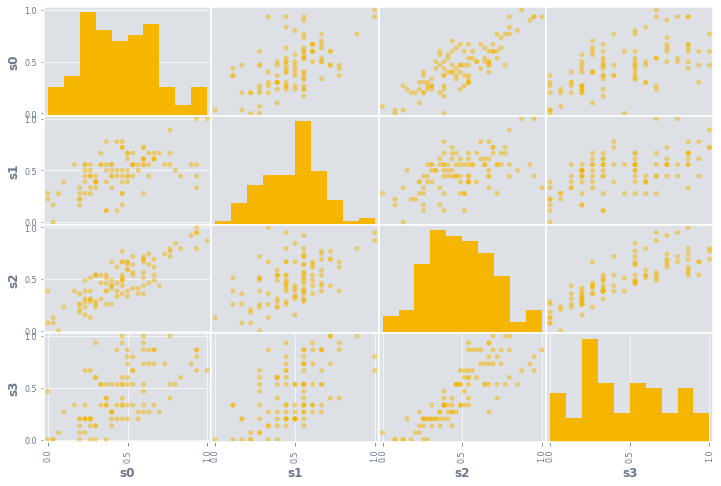

In [8]:
axs = pd.plotting.scatter_matrix(scaled)

Split into test and train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(scaled, np.array(species), test_size=0.33, random_state=42)

In [10]:
min_max = scaler.inverse_transform([[0 for i in scaled.columns],
                                    [1 for i in scaled.columns]])
min_max_vals = pd.DataFrame(index=["min", "max"])
for i, col in enumerate(scaled.columns):
    min_max_vals[col] = [min_max[0][i], min_max[1][i]]

## Classifier Training
and prediction

In [11]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
print(clf.feature_importances_)

[0.07650935 0.020033   0.5463284  0.35712925]


In [13]:
preds = clf.predict(X_test)
certs = clf.predict_proba(X_test)

In [14]:
confusion = [tn, fp, fn, tp] = confusion_matrix(preds, y_test).ravel()
tn, fp, fn, tp = [i/len(preds) * 100 for i in confusion]
print("Results separated for inspection.")
print("+-------+----------+----------+")
print("|       | Positive | Negative |")
print("+-------+----------+----------+")
print("| True  | {:7.3f}% | {:7.3f}% |".format(tp, tn))
print("+-------+----------+----------+")
print("| False | {:7.3f}% | {:7.3f}% |".format(fp, fn))
print("+-------+----------+----------+")

Results separated for inspection.
+-------+----------+----------+
|       | Positive | Negative |
+-------+----------+----------+
| True  |  30.303% |  54.545% |
+-------+----------+----------+
| False |  12.121% |   3.030% |
+-------+----------+----------+


## Naive Monte Carlo Integration

The key equation for this estimation of density is:

$$ I = \{ \frac{1}{n} \sum^n_{i=1} f(x_i, \frac{q}{y}) \}^y_{q=0} $$

where 

* $I$ is the dimension the kernel density is being estimated of.

* $n$ is the number of samples taken.

* $f$ is the density function.

* $x$ are randomly selected values from the function, excluding $y$.

* $y$ is the resolution of $I$ (number of samples, equally spaced).

In [15]:
def naive_mc_integrate(df, column, clf, n=100, Y=np.linspace(0, 1, 11), v=True):
    y_column = column  # The dimension to estimate kde of.
    y_index = df.columns.get_loc(y_column)  # The index of that dimension.
    f = lambda x: clf.predict_proba([x])[0][1]
    d = df.shape[1] # Number of dimensions.
    
    I = []
    for q in Y:
        q_val = []
        for i in range(n):
            # Draw random sample from the sample space.
            D = np.random.uniform(0, 1, d)
            D[y_index] = q

            # Append the density of the prediction at a point.
            prediction = f(D)
            q_val.append(prediction)

        q_val = sum(q_val) / n
        I.append(q_val)
        
    I = np.array(I)
    if v:
        print("Integration complete for", column)
    return I

In [16]:
y_vals = np.linspace(0, 1, 31)
s0_kde = naive_mc_integrate(df, "s0", clf, Y=y_vals)
s1_kde = naive_mc_integrate(df, "s1", clf, Y=y_vals)
s2_kde = naive_mc_integrate(df, "s2", clf, Y=y_vals)
s3_kde = naive_mc_integrate(df, "s3", clf, Y=y_vals)

Integration complete for s0
Integration complete for s1
Integration complete for s2
Integration complete for s3


### 1D KDE Visualization

In [17]:
viz_df = pd.DataFrame({"s0_kde": s0_kde-0.5,
                       "s1_kde": s1_kde-0.5,
                       "s2_kde": s2_kde-0.5,
                       "s3_kde": s3_kde-0.5,
                       "Position": np.round(y_vals, 2)})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


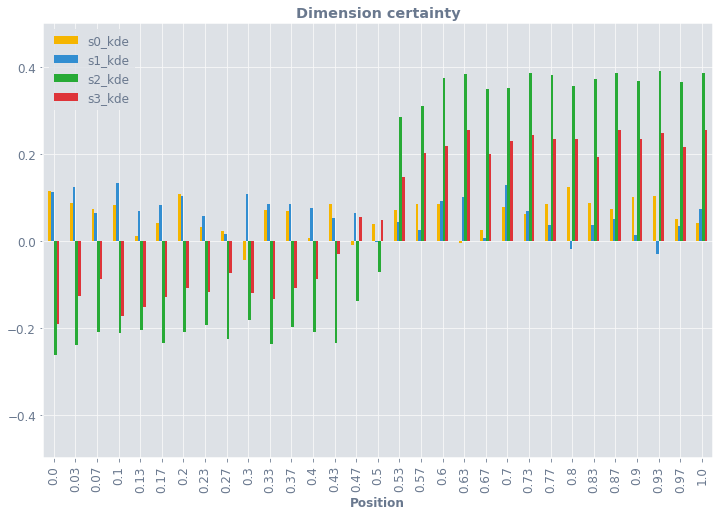

In [18]:
viz_df.plot.bar(ylim=(-0.5, 0.5), x="Position", title="Dimension certainty")

### 2D KDE Visualization

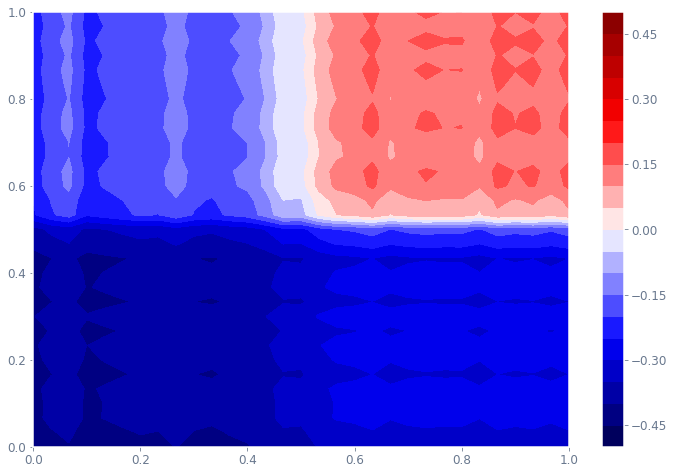

In [19]:
Xm, Ym = np.meshgrid(y_vals, y_vals)
Zm = [[(i*j)-0.5 for i in s3_kde] for j in s2_kde]
contours = plt.contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 21), cmap="seismic")
# plt.clabel(contours, inline=True)
plt.colorbar();

## VEGAS Monte Carlo Integration

### Density Estimation
By taking samples from the area with the most samples, a much more accurate interpretation can be made

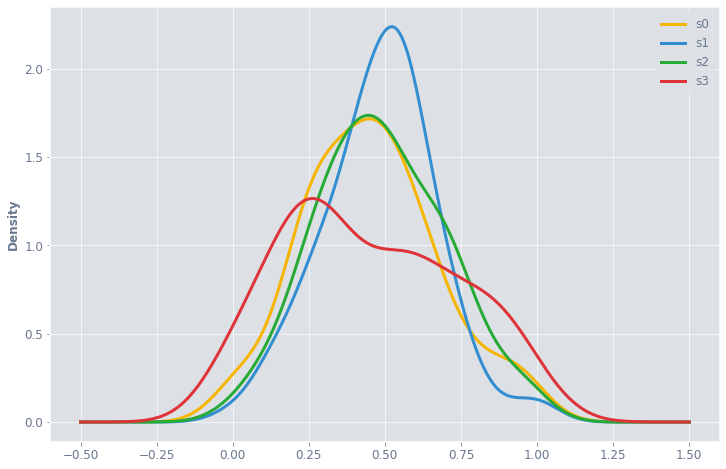

In [20]:
scaled.plot.density()

In [21]:
ker = KernelDensity(0.02).fit(scaled)

In [22]:
D = pd.DataFrame(ker.sample(100))

In [23]:
tmp = pd.DataFrame(D)

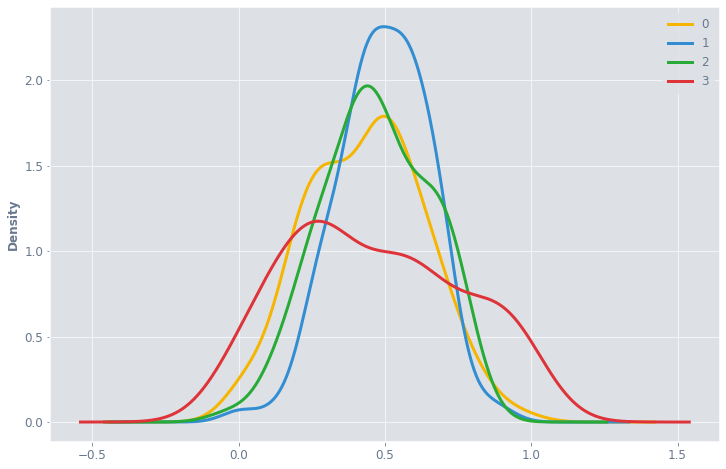

In [24]:
tmp.plot.density()

As can be seen, the sampling method here allows samples to be drawn from a rate described by the kernel density.

### Sample Retrieval

The key equation for this estimation of density is:

$$ I = \{ \frac{1}{n} \sum^n_{i=1} f(x_i) \}^y_{q=0} $$

where 

* $I$ is the dimension the kernel density is being estimated of.

* $n$ is the number of samples taken.

* $f$ is the density function.

* $x$ are randomly selected samples according to the density of the total sample space.

* $y$ is the resolution of $I$ (number of samples, spaced randomly according to kernel density of that axis).

In [36]:
def vegas_mc_integrate(df, f, n=100, v=True):
    kernel = KernelDensity(0.02).fit(df)
    
    # Draw random sample from the sample space.
    D = pd.DataFrame(kernel.sample(n))
    D.columns = df.columns

    # Append the density of the prediction at a point.
    prediction = f(D)
    
    # Select only second index of prediction pairs.
    prediction = np.array([i[1] for i in prediction])
    
    D["prediction"] = prediction
    return D

In [37]:
D = vegas_mc_integrate(scaled, clf.predict_proba, n=10000)

Text(0.5, 1.0, 's2 value and certainty classification')

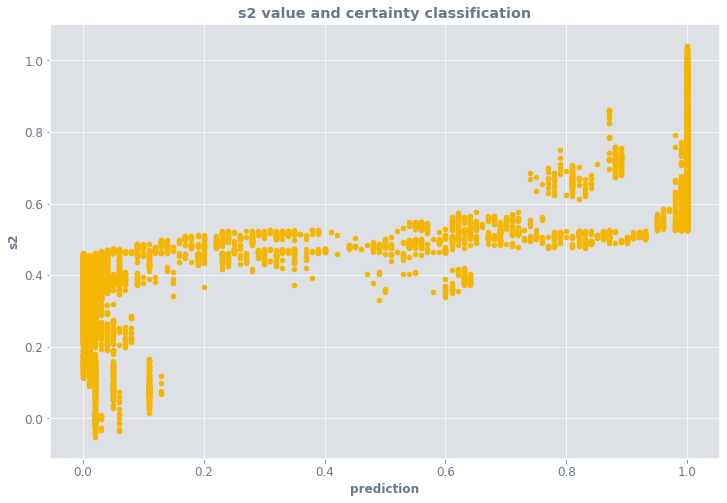

In [38]:
D.plot.scatter(x="prediction", y="s2")
plt.title("s2 value and certainty classification")

### KDE from Binning

In [28]:
D.head()

,s0,s1,s2,s3,prediction
0,0.050229,0.130966,0.073771,0.023148,0.02
1,0.269157,0.512359,0.288174,0.203959,0.00
2,0.188570,0.189126,0.262638,0.191276,0.01
3,0.467909,0.149297,0.390040,0.209022,0.04
4,0.922964,0.341884,1.009644,0.855079,1.00


In [29]:
resolution = 25
res_vals = np.linspace(-0.0, 1.0, resolution)
D_bins = pd.DataFrame()
for col in D.columns[:-1]:
    tmp = D[[col, "prediction"]]
    tmp["bin"] = pd.cut(tmp[col], bins=res_vals)
    tmp = tmp.sort_values(by="bin")
    tmp = tmp.groupby("bin").mean()
    # Select mid value of interval as index.
    D_bins[col] = tmp["prediction"]

# Replace nan values with 0.5 as that is the completely uncertain value.
D_bins = D_bins.fillna(0.5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 1D KDE Visualization

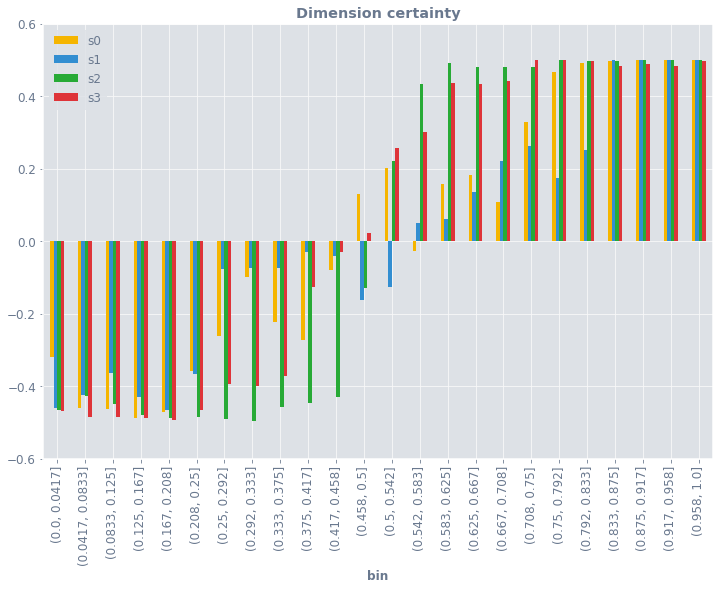

In [30]:
# Shifting everything down 0.5 makes 0 the uncertain value.
D_mid_bins = copy.deepcopy(D_bins)
for col in D_mid_bins[:-1]:
    D_mid_bins[col] = D_mid_bins[col] - 0.5
D_mid_bins.plot.bar(xlim=(-0.15, 1.15), ylim=(-0.6, 0.6), title="Dimension certainty")

### 2D KDE Visualization

In [31]:
x_col = "s2"
y_col = "s3"

24
[-0.467236929421689, -0.42636242066751295, -0.4488868566986267, -0.48088251352400085, -0.48823336003203843, -0.4842321585903085, -0.49084359448518133, -0.49648107929515417, -0.45701787181237197, -0.44550480176211443, -0.43049088923328477, -0.1307621485696996, 0.22030992654429327, 0.432500731139148, 0.49115904232905616, 0.47971199348461857, 0.4815385132158587, 0.4797293408311165, 0.498727027577602, 0.4982664696369822, 0.49695760913095743, 0.4999118942731279, 0.4999118942731279, 0.4999118942731279]


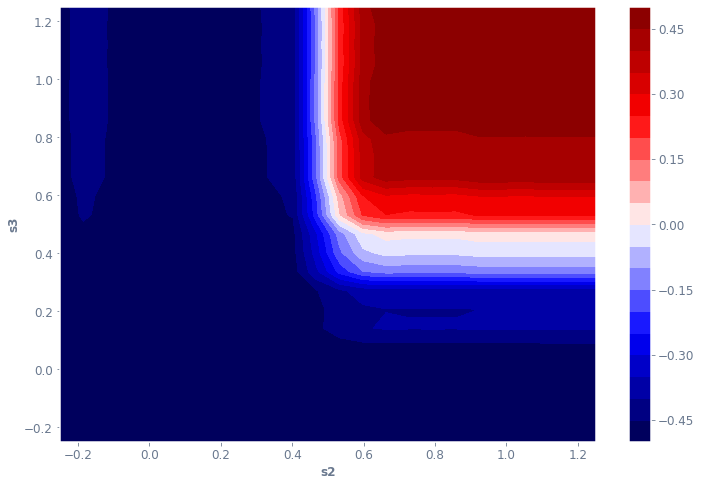

In [32]:
res_sub = np.linspace(-0.25, 1.25, resolution-1)
Xm, Ym = np.meshgrid(res_sub, res_sub)
Zm = [[(i * j)-0.5 for i in D_bins[x_col]] for j in D_bins[y_col]]
print(len(Xm))
print(max(Zm))
contours = plt.contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 21), cmap="seismic")
plt.ylabel(y_col)
plt.xlabel(x_col)
# plt.clabel(contours, inline=True)
plt.colorbar();

In [33]:
print(min_max_vals)

      s0   s1   s2   s3
min  4.9  2.0  3.0  1.0
max  7.9  3.8  6.9  2.5


In [34]:
min_max_vals["s0"]["min"]

4.9

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


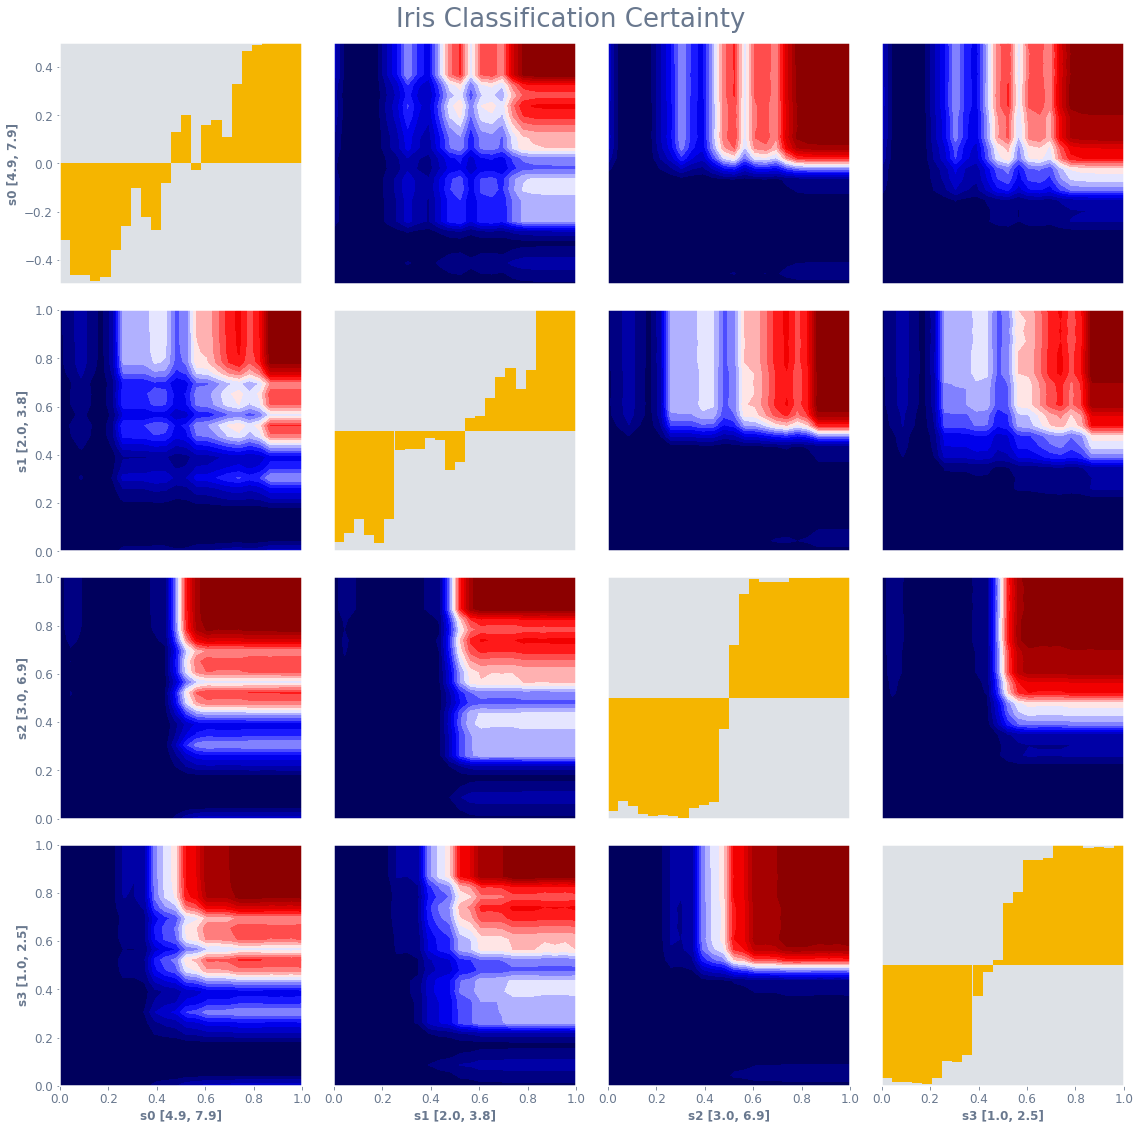

In [35]:
def scatter_plot(D_bins):
    # Some thanks to https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    np.random.seed(42)
    cols = D_bins.columns
    n_cols = len(D_bins.columns)
    fig, axes = plt.subplots(nrows=n_cols, ncols=n_cols,
                             figsize=(n_cols * 4, n_cols * 4))

    # Hide all ticks and labels
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # Set up ticks only on one side for the "edge" subplots...
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')

    res_sub = np.linspace(-0.0, 1.0, len(D_bins))
    Xm, Ym = np.meshgrid(res_sub, res_sub)

    # Plot the data.
    for i, j in zip(*np.triu_indices_from(axes, k=1)):
        for x, y in [(i, j), (j, i)]:
            Zm = [[(i * j)-0.5 for i in D_bins[cols[x]]] for j in D_bins[cols[y]]]
            axes[x, y].contourf(Xm, Ym, Zm, levels=np.linspace(-0.5, 0.5, 21), cmap="seismic")

    # Add bar charts as diagonal plots.
    for i, col in enumerate(cols):
        bar_vals = D_bins[col] - 0.5
        # Select mid values of intervals for x values.
        x = [i.mid for i in np.array(bar_vals.keys())]
        y = bar_vals.values
        axes[i, i].bar(x=x, height=y, width=1/len(x))
        axes[i, i].set_xlim(0.0, 1.0)
        axes[i, i].set_ylim(-0.5, 0.5)
        axes[i, i].grid(False)

    # Add X labels to all of bottom row.
    for i, _ in enumerate(cols):
        axes[n_cols-1, i].xaxis.set_visible(True)
        axes[n_cols-1, i].set_xlabel(cols[i] + " [" + str(min_max_vals[cols[i]]["min"]) + 
                                     ", " + str(min_max_vals[cols[i]]["max"]) + "]")
        
        axes[i, 0].yaxis.set_visible(True)
        axes[i, 0].set_ylabel(cols[i] + " [" + str(min_max_vals[cols[i]]["min"]) + 
                                     ", " + str(min_max_vals[cols[i]]["max"]) + "]")

    fig.suptitle("Iris Classification Certainty", size="26")
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
scatter_plot(D_bins)